# Camera Calibration Example

## Generate data

In [1]:
%cd ..

/mnt/d/CodingProjects/zodiacal-polarized


In [2]:
import os
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from scipy.optimize import least_squares
from scipy.interpolate import griddata
from tqdm import tqdm

# import the necessary modules
from zodipol.utils.argparser import ArgParser
from zodipol.zodipol import Zodipol, Observation
from zodipol.visualization.skymap_plots import plot_satellite_image, plot_satellite_image_indices, plot_skymap_indices, plot_skymap
from zodipol.estimation.estimate_signal import estimate_IQU
from zodipy_local.zodipy_local import IQU_to_image

In [3]:
# magics
%reload_ext autoreload
%autoreload 2

In [4]:
parser = ArgParser(args=['-res', '300', '200', '--fov', '5', '-dir', '90', '40', '-par', '-ip', 'exposure_time', '10*u.s', '-nr', '50', '--isl'])

In [5]:
zodipol = Zodipol(polarizance=parser["polarizance"], fov=parser["fov"], n_polarization_ang=parser["n_polarization_ang"], parallel=parser["parallel"], n_freq=parser["n_freq"], planetary=parser["planetary"], isl=parser["isl"], resolution=parser["resolution"], imager_params=parser["imager_params"])

Full-sky images

In [54]:
freq = (600 * u.nm).to('Hz', equivalencies=u.spectral())

In [52]:
(zodipol.isl.frequency).to('nm', equivalencies=u.spectral())

<Quantity [681.34649545, 674.08955053, 666.9855623 , 660.02974531,
           653.2175117 , 646.54446107, 640.00637101, 633.59918821,
           627.31902004, 621.16212672, 615.12491382, 609.20392535,
           603.39583708, 597.69745037, 592.10568628, 586.61758002,
           581.23027571, 575.94102144, 570.74716453, 565.64614717] nm>

In [60]:
np.median(zodipol.isl.interpolate_freq(freq))

<Quantity 58.22726084 nW / (m2 sr um)>

In [59]:
np.median(zodipol.isl.interpolate_freq(freq)).to('W / sr um m2')

<Quantity 5.82272608e-08 W / (m2 sr um)>

In [6]:
obs_f = zodipol.create_full_sky_observation(nside=64)

In [82]:
dfdw = -np.gradient(zodipol.frequency) / np.gradient(zodipol.wavelength)
unpol = (obs_f.I * dfdw).to('10^-8 W / sr um m2')

In [84]:
np.median(unpol, axis=1)

<Quantity [ 83.20850159, 103.75753084,  83.71892439, ...,  87.37131706,
            86.23683346,  87.36346523] 1e-08 W / (m2 sr um)>

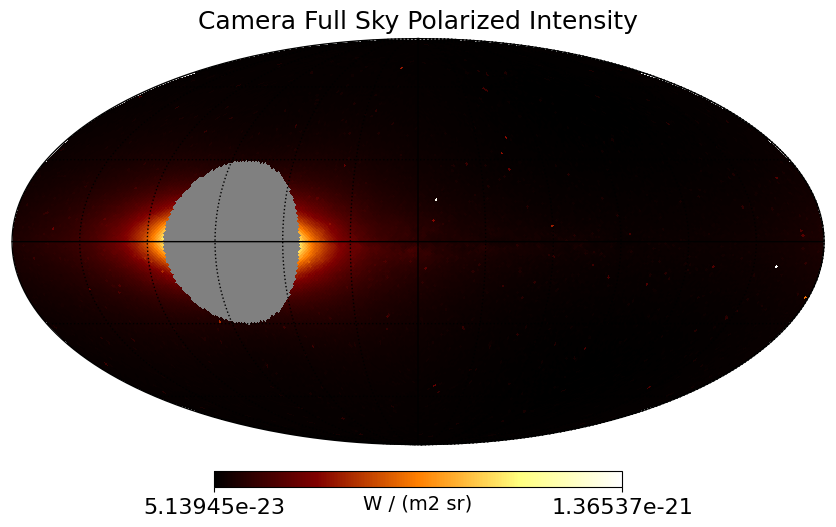

In [8]:
camera_intensity_f = zodipol.make_camera_images(obs_f, n_realizations=parser["n_realizations"], add_noise=True)
plot_skymap(camera_intensity_f[..., 0], title="Camera Full Sky Polarized Intensity", saveto='outputs/camera_fullsky_intensity_sa.pdf')

Satellite view images

In [18]:
direction = [90, 30] * u.deg

In [19]:
obs_s = zodipol.create_observation(theta=direction[0], phi=direction[1], roll=0*u.deg, lonlat=False, new_isl=parser["new_isl"])
camera_intensity = zodipol.make_camera_images(obs_s, n_realizations=parser["n_realizations"], add_noise=True)

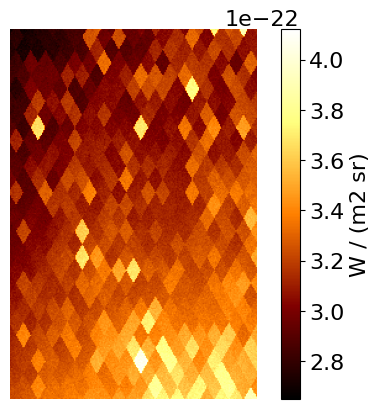

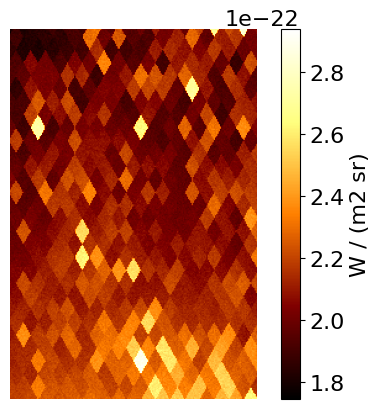

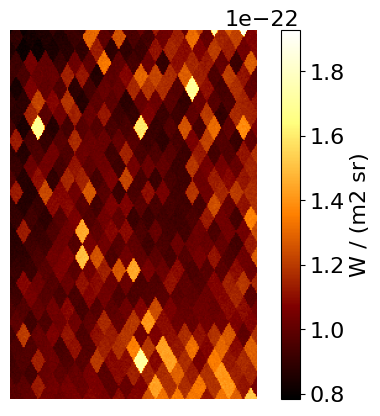

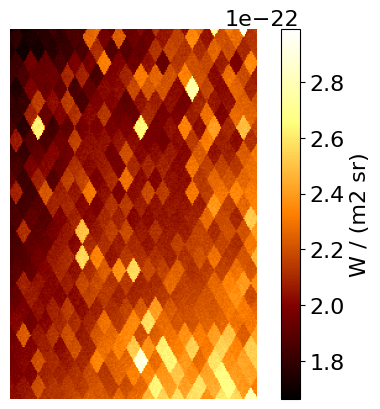

In [20]:
plot_satellite_image_indices(camera_intensity, 4, resolution=parser["resolution"], saveto='outputs/camera_intensity_sat.pdf')

## Camera polarizer angler calibration
Here we assume a constant polarizer angle shift, and calibrate the camera angle accordingly using a single projection

In [7]:
polarizance = parser["polarizance"]  # Polarizance of the observation
polarization_angle_diff = np.pi / parser["n_polarization_ang"]  # Polarization angle difference between the polarization angles

polarization_shift_list = np.linspace(0, np.pi, 10)
calibration_results = []
for polarization_shift in polarization_shift_list:
    polarization_angle = polarization_shift + parser["polarization_angle"]  # Polarization angle of the observation
    df_ind = polarization_angle_diff * np.arange(parser["n_polarization_ang"])
    make_img = lambda eta: zodipol.make_camera_images(obs_s, polarizance, eta+df_ind, n_realizations=parser["n_realizations"], fillna=0, add_noise=False)

    polarization_angle_res = []
    for ii in range(10):
        camera_intensity_real = zodipol.make_camera_images(obs_s, polarizance, polarization_angle, n_realizations=parser["n_realizations"], fillna=0, add_noise=True)
        cost_function = lambda eta: 1e23 * (make_img(eta) - camera_intensity_real).value.flatten()
        res = least_squares(cost_function, x0=0, bounds=(-np.pi/2, np.pi/2))
        polarization_angle_res.append(res.x)
    calibration_results.append(np.array(polarization_angle_res))
    print(f"Estimated polarization angle for eta={polarization_shift:.2f}: {np.mean(polarization_angle_res)%np.pi:.2f} +/- {np.std(polarization_angle_res):.2f} rad")
calibration_results = np.array(calibration_results).squeeze()

Estimated polarization angle for eta=0.00: 0.00 +/- 0.00 rad
Estimated polarization angle for eta=0.35: 0.35 +/- 0.00 rad
Estimated polarization angle for eta=0.70: 0.69 +/- 0.00 rad
Estimated polarization angle for eta=1.05: 1.05 +/- 0.00 rad
Estimated polarization angle for eta=1.40: 1.39 +/- 0.00 rad
Estimated polarization angle for eta=1.75: 1.75 +/- 0.00 rad
Estimated polarization angle for eta=2.09: 2.09 +/- 0.00 rad
Estimated polarization angle for eta=2.44: 2.45 +/- 0.00 rad
Estimated polarization angle for eta=2.79: 2.79 +/- 0.00 rad
Estimated polarization angle for eta=3.14: 0.00 +/- 0.00 rad


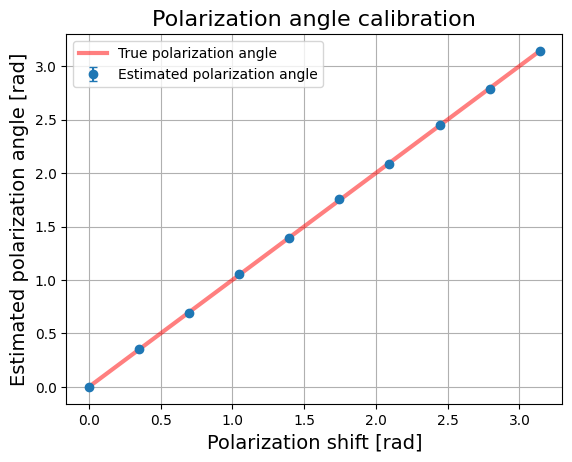

In [8]:
calib_mean = np.unwrap(calibration_results.mean(axis=1), period=np.pi)
calib_std = calibration_results.std(axis=1)

plt.figure()
plt.errorbar(polarization_shift_list, calib_mean, yerr=calib_std, fmt='o', capsize=3, label="Estimated polarization angle")
plt.plot(polarization_shift_list, polarization_shift_list, c='r', alpha=0.5, lw=3, label="True polarization angle")
plt.xlabel("Polarization shift [rad]", fontsize=14)
plt.ylabel("Estimated polarization angle [rad]", fontsize=14)
plt.title("Polarization angle calibration", fontsize=16)
plt.grid()
plt.legend()
plt.savefig('outputs/global_polarization_angle_estimation.pdf')
plt.show()

## Camera polarizance calibration
Here we assume a constant polarizance issues, and calibrate the camera angle accordingly using a singe projection.

In [215]:
polarizance_list = np.linspace(0.6, 1, 10)  # Polarizance of the observation
calibration_results = []
for polarizance in polarizance_list:
    make_img = lambda p: zodipol.make_camera_images(obs_s, p, parser["polarization_angle"], n_realizations=parser["n_realizations"], fillna=0, add_noise=False)

    polarization_angle_res = []
    pbar = tqdm(range(3))
    for ii in pbar:
        camera_intensity_real = zodipol.make_camera_images(obs_s, polarizance, parser["polarization_angle"], n_realizations=parser["n_realizations"], fillna=0, add_noise=True)
        cost_function = lambda p: 1e23*(make_img(p) - camera_intensity_real).value.flatten()
        res = least_squares(cost_function, x0=1, bounds=(0, 1), diff_step=20)
        pbar.set_description(f"Iteration results for P={polarizance:.2f}: {float(res.x):.2f}")
        polarization_angle_res.append(res.x)
    calibration_results.append(np.array(polarization_angle_res))
    print(f"Estimated Polarizance for P={polarizance:.2f} -> {np.mean(polarization_angle_res):.2f} +/- {np.std(polarization_angle_res):.2f}")
calibration_results = np.array(calibration_results).squeeze()

Iteration results for P=0.60: 0.61: 100%|██████████| 3/3 [03:11<00:00, 63.80s/it]


Estimated Polarizance for P=0.60 -> 0.61 +/- 0.00


Iteration results for P=0.64: 0.66: 100%|██████████| 3/3 [03:12<00:00, 64.17s/it]


Estimated Polarizance for P=0.64 -> 0.66 +/- 0.00


Iteration results for P=0.69: 0.70: 100%|██████████| 3/3 [03:11<00:00, 63.78s/it]


Estimated Polarizance for P=0.69 -> 0.70 +/- 0.00


Iteration results for P=0.73: 0.74: 100%|██████████| 3/3 [02:41<00:00, 53.82s/it]


Estimated Polarizance for P=0.73 -> 0.74 +/- 0.00


Iteration results for P=0.78: 0.79: 100%|██████████| 3/3 [03:36<00:00, 72.03s/it]


Estimated Polarizance for P=0.78 -> 0.79 +/- 0.00


Iteration results for P=0.82: 0.83: 100%|██████████| 3/3 [04:29<00:00, 89.99s/it]


Estimated Polarizance for P=0.82 -> 0.83 +/- 0.00


Iteration results for P=0.87: 0.87: 100%|██████████| 3/3 [04:41<00:00, 93.87s/it]


Estimated Polarizance for P=0.87 -> 0.87 +/- 0.00


Iteration results for P=0.91: 0.92: 100%|██████████| 3/3 [04:30<00:00, 90.33s/it]


Estimated Polarizance for P=0.91 -> 0.92 +/- 0.00


Iteration results for P=0.96: 0.96: 100%|██████████| 3/3 [03:43<00:00, 74.50s/it]


Estimated Polarizance for P=0.96 -> 0.96 +/- 0.00


Iteration results for P=1.00: 1.00: 100%|██████████| 3/3 [02:56<00:00, 58.77s/it]

Estimated Polarizance for P=1.00 -> 1.00 +/- 0.00


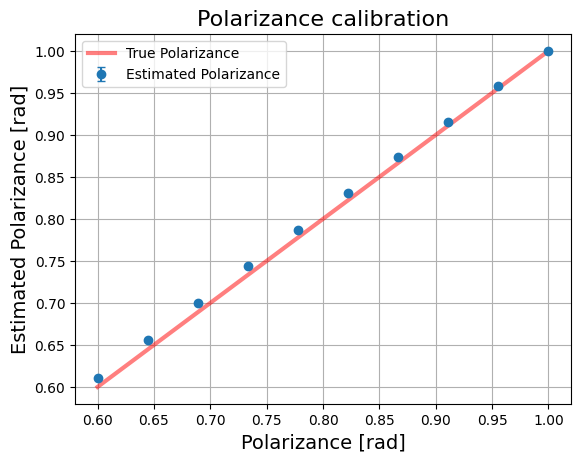

In [216]:
calib_mean = calibration_results.mean(axis=1)
calib_std = calibration_results.std(axis=1)

plt.figure()
plt.errorbar(polarizance_list, calib_mean, yerr=calib_std, fmt='o', capsize=3, label="Estimated Polarizance")
plt.plot(polarizance_list, polarizance_list, c='r', alpha=0.5, lw=3, label="True Polarizance")
plt.xlabel("Polarizance [rad]", fontsize=14)
plt.ylabel("Estimated Polarizance [rad]", fontsize=14)
plt.title("Polarizance calibration", fontsize=16)
plt.grid()
plt.legend()
plt.savefig('outputs/global_polarizance_estimation.pdf')
plt.show()

## Camera Per-Pixel calibration
Here we take multiple observations of the same scene with rotations. We then use the camera images to calibrate the per-pixel polarization angles and polarizances.

In [6]:
def estimate_polarizance(obs_rot, images_orig, polarization_angle, n_pol=20, disable=False):
    # perform grid search for the polarizance
    p_t = np.linspace(0.6, 1, n_pol)
    img = [np.stack([zodipol.make_camera_images(o, p, polarization_angle, n_realizations=1, add_noise=False) for p in p_t], axis=-1) for o in tqdm(obs_rot, disable=disable)]
    img_stack = np.stack(img, axis=-2)
    diff_resh = (img_stack - images_orig[..., None]).value.reshape(parser["resolution"] + [parser["n_polarization_ang"], n_rotations, len(p_t)])

    c = np.nansum((1e23 * diff_resh) ** 2, axis=(-3, -2))
    p_est = p_t[np.argmin(np.nan_to_num(c, nan=np.inf), axis=-1)]
    return p_est

In [7]:
def estimate_polarization_angle(obs_rot, images_orig, polarizance, n_pol=20, disable=False):
    a_t = np.deg2rad(np.linspace(-15, 15, n_pol))
    img = [np.stack([zodipol.make_camera_images(o, polarizance, parser["polarization_angle"]+p, n_realizations=1, add_noise=False) for p in a_t], axis=-1) for o in tqdm(obs_rot, disable=disable)]
    img_stack = np.stack(img, axis=-1)
    diff_resh = (img_stack - images_orig[..., None, :]).value.reshape(tuple(parser["resolution"]) + img_stack.shape[1:])

    c = np.nansum((1e21 * diff_resh) ** 2, axis=(-3, -1))
    p_est = a_t[np.argmin(np.nan_to_num(c, nan=np.inf), axis=-1)]
    return p_est

In [8]:
def plot_polarizance_comp(p_est, polarizance_real, saveto=None):
    # Compare the per-pixel polarizance and estimated polarizance
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    c1 = ax1.imshow(p_est, vmin=0.75, vmax=0.95)
    ax1.set_title('Estimated Per-Pixel\n Polarizance', fontsize=14)
    ax1.set_xlabel('X [pix]', fontsize=12)
    ax1.set_ylabel('Y [pix]', fontsize=12)

    c2 = ax2.imshow(polarizance_real, vmin=0.75, vmax=0.95)
    ax2.set_title('Actual Per-Pixel\n Polarizance', fontsize=14)
    ax2.set_xlabel('X [pix]', fontsize=12)
    ax2.set_ylabel('Y [pix]', fontsize=12)

    cbar = fig.colorbar(c2, ax=[ax1, ax2])
    cbar.set_label('Polarizance', fontsize=12)

    if saveto is not None:
        plt.savefig(saveto)
    plt.show()

In [9]:
def plot_polarization_angle_comp(p_est, polarization_angle_spatial_diff, saveto=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    c1 = ax1.imshow(p_est, vmin=-0.2, vmax=0.2)
    ax1.set_title('Estimated Per-Pixel\n Polarization Angle', fontsize=14)
    ax1.set_xlabel('X [pix]', fontsize=12)
    ax1.set_ylabel('Y [pix]', fontsize=12)

    c2 = ax2.imshow(polarization_angle_spatial_diff, vmin=-0.2, vmax=0.2)
    ax2.set_title('Actual Per-Pixel\n Polarization Angle', fontsize=14)
    ax2.set_xlabel('X [pix]', fontsize=12)
    ax2.set_ylabel('Y [pix]', fontsize=12)

    cbar = fig.colorbar(c2, ax=[ax1, ax2])
    cbar.set_label('Polarization Angle [rad]', fontsize=12)

    if saveto is not None:
        plt.savefig(saveto)
    plt.show()

In [25]:
def get_observations(n_rotations):
    rotations_file_path = 'saved_models/self_calibration_temp.pkl'
    rotation_list = np.linspace(0, 360, n_rotations, endpoint=False)
    if os.path.isfile(rotations_file_path):
        # saved rotations pickle file exists
        with open(rotations_file_path, 'rb') as f:
            obs_rot = pkl.load(f)
        ind_list = np.linspace(0, len(obs_rot), n_rotations, endpoint=False, dtype=int)
        rotation_list = np.linspace(0, 360, len(obs_rot), endpoint=False)[ind_list]
        obs_rot = [obs_rot[ii] for ii in ind_list]
    else:
        obs_rot = [zodipol.create_observation(theta=parser["direction"][0], phi=parser["direction"][1], roll=t * u.deg,
                                              lonlat=False, new_isl=parser["new_isl"]) for t in tqdm(rotation_list)]
        with open(rotations_file_path, 'wb') as f:
            pkl.dump(obs_rot, f)
    return obs_rot, rotation_list

In [26]:
obs_rot, rotation_list = get_observations(5)

Calibrate polarizance

In [15]:
# Polarizance calibration example
polarizance, _ = np.meshgrid(np.linspace(0.8, 0.9, parser["resolution"][0]), np.arange(parser["resolution"][1]),
                   indexing='ij')
polarizance = polarizance.reshape((len(obs_rot[0]), 1, 1))
obs_orig = [zodipol.make_camera_images(o, polarizance, parser["polarization_angle"],
                                       n_realizations=parser["n_realizations"], add_noise=True) for o in tqdm(obs_rot)]
images_orig = np.stack(obs_orig, axis=-1)


100%|██████████| 13/13 [01:39<00:00,  7.63s/it]


In [16]:
# perform grid search for the polarizance
p_est = estimate_polarizance(obs_rot, images_orig, parser["polarization_angle"])
polarizance_real = polarizance.reshape(parser["resolution"])
error = p_est - polarizance_real


100%|██████████| 13/13 [00:26<00:00,  2.07s/it]


In [17]:
# calculate the angle of polarization error variance
mean_err = np.mean(error)
estimation_std = np.std(p_est - polarizance_real)
bias = np.sqrt(np.mean(error ** 2) - estimation_std ** 2)
print(f"Bias: {bias:.4f}")
print(f"Std: {estimation_std:.4f}")
print(f"Mean Error: {mean_err:.4f}")

Bias: 0.0003
Std: 0.0065
Mean Error: -0.0003


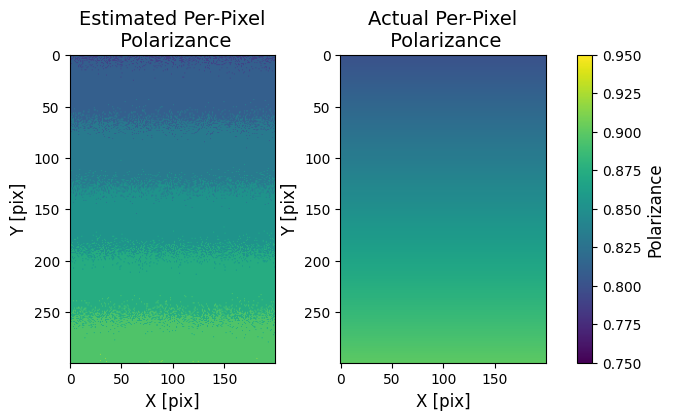

In [18]:
# Compare the per-pixel polarizance and estimated polarizance
plot_polarizance_comp(p_est, polarizance_real, saveto=f"outputs/polarizance_estimation.pdf")

Now doing the same for the per-pixel angle of polarization.

In [15]:
polarization_angle = parser["polarization_angle"]
polarization_angle_spatial_diff, _ = np.meshgrid(np.deg2rad(np.linspace(-10, 10, parser["resolution"][0])), np.arange(parser["resolution"][1]), indexing='ij')
polarization_angle_real = polarization_angle[None, None :] + polarization_angle_spatial_diff.flatten()[:, None, None]

In [16]:
# Polarizance calibration example
polarizance = 1
obs_orig = [zodipol.make_camera_images(o, polarizance, polarization_angle_real,
                                       n_realizations=parser["n_realizations"], add_noise=True) for o in tqdm(obs_rot)]
images_orig = np.stack(obs_orig, axis=-1)

100%|██████████| 6/6 [00:49<00:00,  8.18s/it]


In [18]:
# perform grid search for the polarizance
p_est = estimate_polarization_angle(obs_rot, images_orig, polarizance)
error = p_est - polarization_angle_spatial_diff

100%|██████████| 6/6 [00:12<00:00,  2.03s/it]


In [19]:
# calculate the angle of polarization error variance
estimation_std = np.std(error)
bias = np.sqrt(np.mean(error ** 2) - estimation_std ** 2)
print(f"Bias: {bias:.4f}")
print(f"Std: {estimation_std:.4f}")

Bias: 0.0001
Std: 0.0143


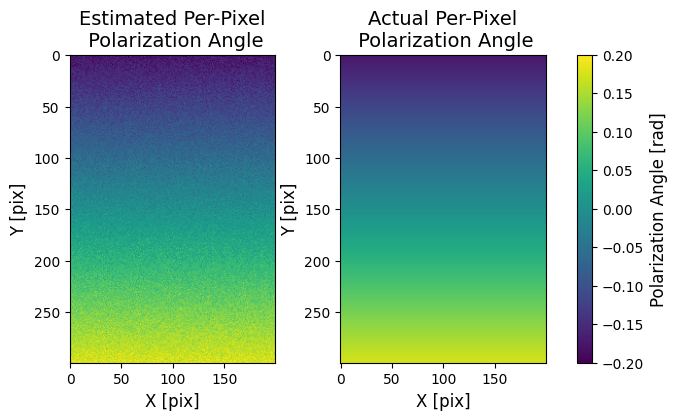

In [20]:
plot_polarization_angle_comp(p_est, polarization_angle_spatial_diff, saveto=f"outputs/polarization_angle_estimation.pdf")

Calibrate both polarizance and polarization angle.

In [29]:
def get_initial_parameters(parser, zodipol):
    polarization_angle = parser["polarization_angle"]
    _, polarization_angle_spatial_diff = np.meshgrid(np.arange(parser["resolution"][0]), np.deg2rad(np.linspace(-10, 10, parser["resolution"][1])), indexing='ij')
    polarization_angle_real = polarization_angle[None, None :] + polarization_angle_spatial_diff.flatten()[:, None, None]

    polarizance, _ = np.meshgrid(np.linspace(0.8, 0.9, parser["resolution"][0]), np.arange(parser["resolution"][1]),
                       indexing='ij')
    polarizance_real = polarizance.reshape((len(obs_rot[0]), 1, 1))

    obs_orig = [zodipol.make_camera_images(o, polarizance_real,polarization_angle_real, n_realizations=1, add_noise=True) for o in tqdm(obs_rot)]
    images_orig = np.stack(obs_orig, axis=-1)
    return images_orig, polarizance_real, polarization_angle_real

In [27]:
def estimate_properties(parser, obs_rot, images, n_itr=5):
    # initial parameters
    polarizance_est = np.ones(parser["resolution"])
    polarization_ang_est = np.zeros(parser["resolution"])
    polarization_ang_est_itr = polarization_angle[None, None :] + polarization_ang_est.flatten()[:, None, None]

    obs_est = [zodipol.make_camera_images(o, polarizance_est.flatten()[:, None, None], polarization_ang_est_itr, n_realizations=1, add_noise=False) for o in tqdm(obs_rot)]
    images_est = np.stack(obs_est, axis=-1)
    cur_error = ((images - images_est) ** 2).sum().value
    err_list = [cur_error]

    for _ in tqdm(range(n_itr)):
        polarizance_est = estimate_polarizance(obs_rot, images, polarization_ang_est_itr, disable=True, n_pol=31)
        polarization_ang_est = estimate_polarization_angle(obs_rot, images, polarizance_est.flatten()[:, None, None], disable=True, n_pol=31)
        polarization_ang_est_itr = polarization_angle[None, None :] + polarization_ang_est.flatten()[:, None, None]
        obs_est = [zodipol.make_camera_images(o, polarizance_est.flatten()[:, None, None], polarization_ang_est_itr, n_realizations=1, add_noise=False) for o in obs_rot]
        images_est = np.stack(obs_est, axis=-1)
        cur_error = ((images - images_est) ** 2).sum().value
        err_list.append(cur_error)
    return err_list, polarizance_est, polarization_ang_est

In [30]:
images_orig, polarizance_real, polarization_angle_real = get_initial_parameters(parser, zodipol)

100%|██████████| 5/5 [00:01<00:00,  4.03it/s]


In [31]:
err_list, polarizance_est, polarization_ang_est = estimate_properties(parser, obs_rot, images_orig, n_itr=5)

  0%|          | 0/5 [00:02<?, ?it/s]

KeyboardInterrupt



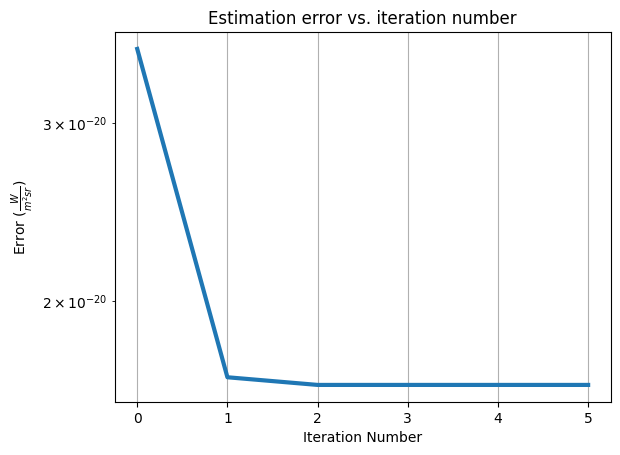

In [16]:
plt.figure()
plt.semilogy(np.sqrt(err_list), lw=3)
plt.grid()
plt.xlabel("Iteration Number")
plt.ylabel("Error ($\\frac{W}{m^2 sr}$)")
plt.title('Estimation error vs. iteration number')
plt.show()

In [24]:
# calculate the angle of polarization error variance
polarizance_error = polarizance_est - polarizance_real.reshape(parser["resolution"])
angle_of_polarization_error = polarization_ang_est.reshape(parser["resolution"]) - polarization_angle_spatial_diff

polarizance_mse = np.mean(polarizance_error ** 2)
polarizance_error_std = np.std(polarizance_error ** 2)

angle_of_polarization_mse = np.mean(angle_of_polarization_error ** 2)
angle_of_polarization_error_std = np.std(angle_of_polarization_error ** 2)

print(f"Polariance MSE: {polarizance_mse:.4f}")
print(f"Polarizance Std: {polarizance_error_std:.4f}")

print(f"Angle Of Polariance MSE: {angle_of_polarization_mse:.4f}")
print(f"Angle Of Polarization Std: {angle_of_polarization_error_std:.4f}")

Polariance MSE: 0.0009
Polarizance Std: 0.0013
Angle Of Polariance MSE: 0.0003
Angle Of Polarization Std: 0.0005


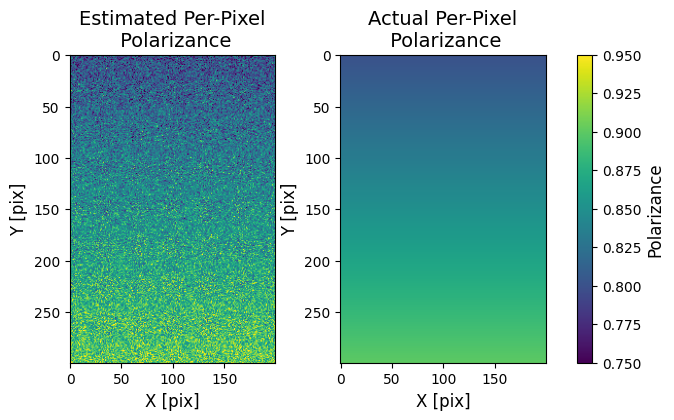

In [18]:
# Compare the per-pixel polarizance and estimated polarizance
plot_polarizance_comp(polarizance_est, polarizance_real.reshape(parser["resolution"]), saveto=f"outputs/polarizance_estimation_both.pdf")

In [20]:
plot_polarization_angle_comp(polarization_ang_est.reshape(parser["resolution"]), polarization_angle_spatial_diff, saveto=f"outputs/polarization_angle_estimation_both.pdf")

Calculate error based on number of observations

In [32]:
error_itr = {'polarizance_mse': [], 'polarizance_error_std': [], 'angle_of_polarization_mse': [], 'angle_of_polarization_error_std': []}
n_rotations_list = np.arange(1, 17, 2)
for n_rotations in n_rotations_list:
    obs_rot, rotation_list = get_observations(n_rotations)
    images_orig, polarizance_real, polarization_angle_real = get_initial_parameters(parser, zodipol)
    err_list, polarizance_est, polarization_ang_est = estimate_properties(parser, obs_rot, images_orig, n_itr=5)

    # calculate the angle of polarization error variance
    polarizance_error = polarizance_est - polarizance_real.reshape(parser["resolution"])
    angle_of_polarization_error = polarization_ang_est.reshape(parser["resolution"]) - polarization_angle_spatial_diff

    error_itr['polarizance_mse'].append(np.mean(polarizance_error ** 2))
    error_itr['polarizance_error_std'].append(np.std(polarizance_error ** 2))
    error_itr['angle_of_polarization_mse'].append(np.mean(angle_of_polarization_error ** 2))
    error_itr['angle_of_polarization_error_std'].append(np.std(angle_of_polarization_error ** 2))

100%|██████████| 5/5 [13:24<00:00, 160.88s/it]


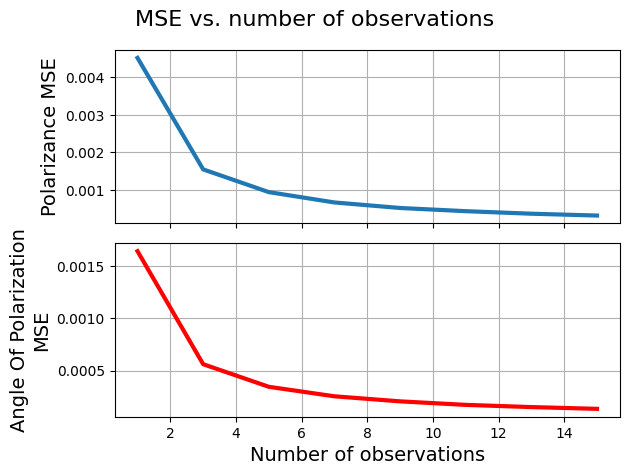

In [47]:
fig, (ax, ax2) = plt.subplots(2,1,sharex=True)
ax.plot(n_rotations_list, error_itr['polarizance_mse'], label='polarizance_mse', lw=3)
ax2.plot(n_rotations_list, error_itr['angle_of_polarization_mse'], label='angle_of_polarization_mse', color='r', lw=3)
ax.set_ylabel('Polarizance MSE', fontsize=14)
ax2.set_ylabel('Angle Of Polarization\nMSE', fontsize=14)
ax2.set_xlabel('Number of observations', fontsize=14)
ax.grid()
ax2.grid()
plt.suptitle('MSE vs. number of observations', fontsize=16)
fig.tight_layout()
plt.savefig(f"outputs/polariz_mse_vs_nobs.pdf")
plt.show()

## Calibrate birefringence

### Birefringence matrix example

In [52]:
delta_val, phi_val = np.pi/4, np.pi/4
biref_amount = zodipol.imager.get_birefringence_mat(delta_val, 'center', flat=True)
biref_angle = zodipol.imager.get_birefringence_mat(phi_val, 'linear', flat=True, angle=-np.pi/4)
biref_mueller = zodipol.imager.get_birefringence_mueller_matrix(biref_amount, biref_angle)

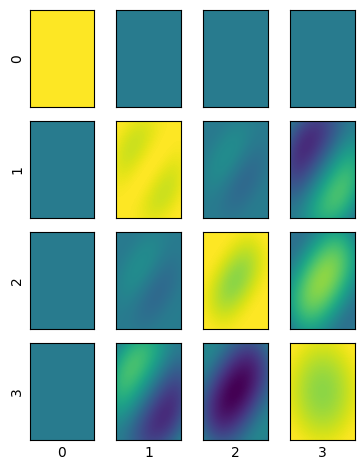

In [53]:
fig, ax = plt.subplots(4,4, sharex='col', sharey='row', subplot_kw={'xticks': [], 'yticks': []})
for i in range(4):
    for j in range(4):
        c = ax[i,j].imshow(biref_mueller[:, i, j].reshape(parser["resolution"]), vmin=biref_mueller.min(), vmax=biref_mueller.max())
        # ax[i,j].get_xaxis().set_visible(False)
        # ax[i,j].get_yaxis().set_visible(False)
ax[0,0].set_ylabel(0)
ax[1,0].set_ylabel(1)
ax[2,0].set_ylabel(2)
ax[3,0].set_ylabel(3)
ax[3,0].set_xlabel(0)
ax[3,1].set_xlabel(1)
ax[3,2].set_xlabel(2)
ax[3,3].set_xlabel(3)
# fig.colorbar(c, ax=ax.ravel().tolist())
plt.tight_layout(w_pad=-15.0, h_pad=1.0)
plt.savefig('outputs/mueller_matrix_example.pdf')
plt.show()

Birefringence image example

In [29]:
# Create observations
obs_biref = zodipol.create_observation(theta=parser["direction"][0], phi=parser["direction"][1], lonlat=False, new_isl=parser["new_isl"])
obs_biref_a = zodipol.imager.apply_birefringence(obs_biref, biref_mueller)
biref_intens = zodipol.make_camera_images(obs_biref_a, parser["polarizance"], parser["polarization_angle"], n_realizations=parser["n_realizations"], add_noise=True)

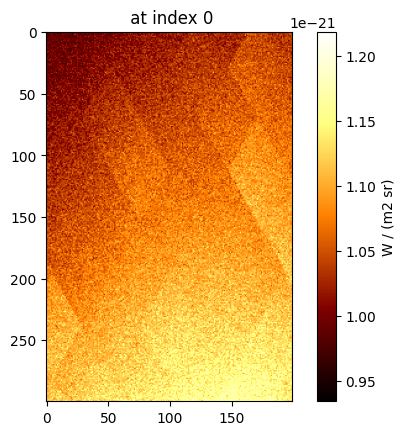

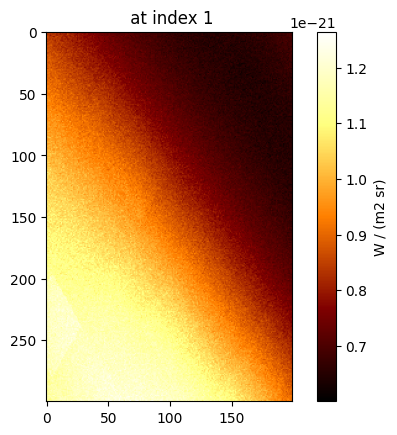

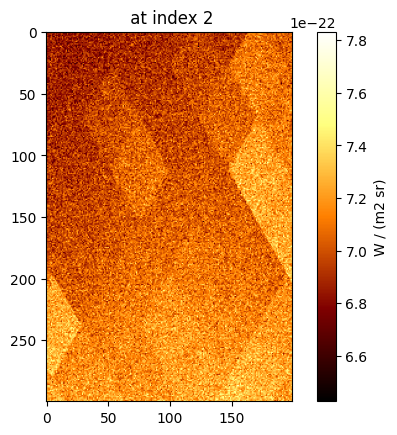

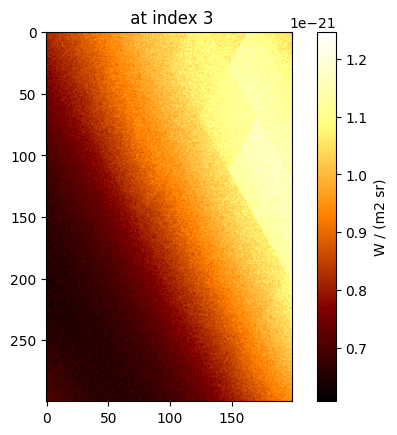

In [30]:
plot_satellite_image_indices(biref_intens, 4, resolution=parser["resolution"])

### Birefringence calibration - unnoised

In [55]:
def make_biref_img(obs, delta, phi, add_noise=False, n_realizations=1, **kwargs):
    if not isinstance(delta, np.ndarray) and not isinstance(delta, np.ndarray):
        delta, phi = np.repeat(delta, len(obs)), np.repeat(phi, len(obs))
    biref_mueller = zodipol.imager.get_birefringence_mueller_matrix(delta, phi)
    biref_obs = zodipol.imager.apply_birefringence(obs, biref_mueller)
    if add_noise:
        biref_camera_intensity = zodipol.make_camera_images(biref_obs, parser["polarizance"], parser["polarization_angle"], n_realizations=n_realizations, add_noise=add_noise, **kwargs)
    else:
        biref_camera_intensity = zodipol.make_camera_images(biref_obs, parser["polarizance"], parser["polarization_angle"], n_realizations=1, add_noise=add_noise, **kwargs)
    return biref_camera_intensity

In [56]:
def estimate_delta(obs, biref_camera_intensity_stack, phi, n_d=20):
    d_t = np.linspace(-np.pi/2, np.pi/2, n_d)
    img = [np.stack([make_biref_img(o, np.full_like(phi, d), phi, n_realizations=1, add_noise=False) for d in d_t], axis=-1) for o in obs]
    img_stack = np.stack(img, axis=-1)
    diff_resh = (img_stack - biref_camera_intensity_stack[..., None, :]).value.reshape(tuple(parser["resolution"]) + img_stack.shape[1:])

    c = np.nansum((1e21 * diff_resh) ** 2, axis=(-3, -1))
    d_est = d_t[np.argmin(np.nan_to_num(c, nan=np.inf), axis=-1)]
    return d_est

In [57]:
def estimate_theta(obs, biref_camera_intensity_stack, delta, n_d=20):
    p_t = np.linspace(-np.pi/2, np.pi/2, n_d)
    img = [np.stack([make_biref_img(o, delta, np.full_like(delta, p), n_realizations=1, add_noise=False) for p in p_t], axis=-1) for o in obs]
    img_stack = np.stack(img, axis=-1)
    diff_resh = (img_stack - biref_camera_intensity_stack[..., None, :]).value.reshape(tuple(parser["resolution"]) + img_stack.shape[1:])

    c = np.nansum((1e21 * diff_resh) ** 2, axis=(-3, -1))
    p_est = p_t[np.argmin(np.nan_to_num(c, nan=np.inf), axis=-1)]
    return p_est

In [58]:
def plot_delta(d_est, delta, saveto=None):
    # Compare the per-pixel polarizance and estimated polarizance
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    c1 = ax1.imshow(d_est, vmin=-np.pi/2, vmax=np.pi/2)
    ax1.set_title('Estimated Per-Pixel\n Birefringence $\delta$', fontsize=14)
    ax1.set_xlabel('X [pix]', fontsize=12)
    ax1.set_ylabel('Y [pix]', fontsize=12)

    c2 = ax2.imshow(delta.reshape(parser["resolution"]), vmin=-np.pi/2, vmax=np.pi/2)
    ax2.set_title('Actual Per-Pixel\n Birefringence $\delta$', fontsize=14)
    ax2.set_xlabel('X [pix]', fontsize=12)
    ax2.set_ylabel('Y [pix]', fontsize=12)

    cbar = fig.colorbar(c2, ax=[ax1, ax2])
    cbar.set_label('Birefringence $\delta$ [rad]', fontsize=12)

    if saveto is not None:
        plt.savefig(saveto)
    plt.show()

In [59]:
def plot_theta(p_est, phi, saveto=None):
    # Compare the per-pixel polarizance and estimated polarizance
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    c1 = ax1.imshow(p_est, vmin=-np.pi/2, vmax=np.pi/2)
    ax1.set_title('Estimated Per-Pixel\n Birefringence $\\theta_{\delta}$', fontsize=14)
    ax1.set_xlabel('X [pix]', fontsize=12)
    ax1.set_ylabel('Y [pix]', fontsize=12)

    c2 = ax2.imshow(phi.reshape(parser["resolution"]), vmin=-np.pi/2, vmax=np.pi/2)
    ax2.set_title('Actual Per-Pixel\n Birefringence $\\theta_{\delta}$', fontsize=14)
    ax2.set_xlabel('X [pix]', fontsize=12)
    ax2.set_ylabel('Y [pix]', fontsize=12)

    cbar = fig.colorbar(c2, ax=[ax1, ax2])
    cbar.set_label('Birefringence $\\theta_{\delta}$ [rad]', fontsize=12)

    if saveto is not None:
        plt.savefig(saveto)
    plt.show()

In [60]:
def plot_mueller(mueller, cbar=False):
    fig, ax = plt.subplots(4,4, sharex='col', sharey='row', subplot_kw={'xticks': [], 'yticks': []})
    for i in range(4):
        for j in range(4):
            c = ax[i,j].imshow(mueller[..., i, j].reshape(parser["resolution"]), vmin=mueller.min(), vmax=mueller.max())
            # ax[i,j].get_xaxis().set_visible(False)
            # ax[i,j].get_yaxis().set_visible(False)
    ax[0,0].set_ylabel(0)
    ax[1,0].set_ylabel(1)
    ax[2,0].set_ylabel(2)
    ax[3,0].set_ylabel(3)
    ax[3,0].set_xlabel(0)
    ax[3,1].set_xlabel(1)
    ax[3,2].set_xlabel(2)
    ax[3,3].set_xlabel(3)
    # fig.colorbar(c, ax=ax.ravel().tolist())
    if cbar:
        fig.colorbar(c, ax=ax.ravel().tolist())
    else:
        plt.tight_layout(w_pad=-15.0, h_pad=1.0)
    plt.savefig('outputs/mueller_matrix_example.pdf')
    plt.show()

In [62]:
def get_observations(n_rotations):
    rotations_file_path = 'saved_models/self_calibration_temp.pkl'
    rotation_list = np.linspace(0, 360, n_rotations, endpoint=False)
    if os.path.isfile(rotations_file_path):
        # saved rotations pickle file exists
        with open(rotations_file_path, 'rb') as f:
            obs_rot = pkl.load(f)
        ind_list = np.linspace(0, len(obs_rot), n_rotations, endpoint=False, dtype=int)
        rotation_list = np.linspace(0, 360, len(obs_rot), endpoint=False)[ind_list]
        obs_rot = [obs_rot[ii] for ii in ind_list]
    else:
        obs_rot = [zodipol.create_observation(theta=parser["direction"][0], phi=parser["direction"][1], roll=t * u.deg,
                                              lonlat=False, new_isl=parser["new_isl"]) for t in tqdm(rotation_list)]
        with open(rotations_file_path, 'wb') as f:
            pkl.dump(obs_rot, f)
    return obs_rot, rotation_list

In [64]:
obs, rotation_list = get_observations(10)

Generate the birefringence images

In [65]:
delta_val, phi_val = np.pi/4, np.pi/4
delta = zodipol.imager.get_birefringence_mat(delta_val, 'center', flat=True)
phi = zodipol.imager.get_birefringence_mat(phi_val, 'linear', flat=True, angle=-np.pi/4)
biref_camera_intensity = [make_biref_img(o, delta, phi, n_realizations=parser["n_realizations"], fillna=0, add_noise=True) for o in obs]
biref_camera_intensity_stack = np.stack(biref_camera_intensity, axis=-1)

In [32]:
plot_satellite_image_indices(biref_camera_intensity_stack[..., 4], 4, resolution=parser["resolution"])

Estimate $\delta$ of birefringence using grid search

In [30]:
d_est = estimate_delta(obs, biref_camera_intensity_stack, phi, n_d=20)
d_error = d_est - delta.reshape(parser["resolution"])

In [63]:
# calculate the angle of polarization error variance
estimation_std = np.std(d_error)
bias = np.sqrt(np.mean(d_error ** 2) - estimation_std ** 2)
print(f"Bias: {bias:.4f}")
print(f"Std: {estimation_std:.4f}")

Bias: 0.0003
Std: 0.0516


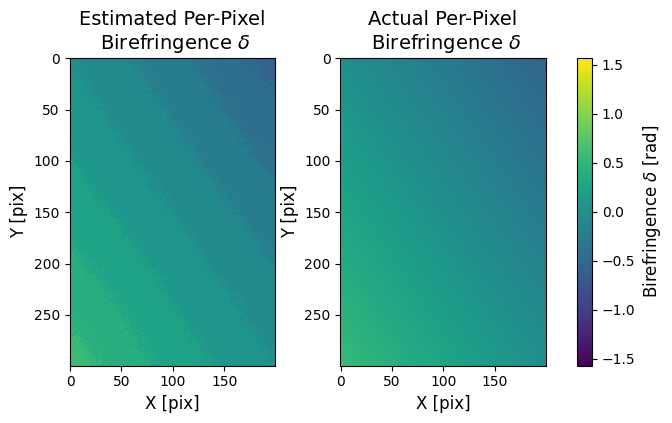

In [67]:
# Compare the per-pixel polarizance and estimated polarizance
plot_delta(d_est, delta)

Estimate $\theta_{\delta}$

In [56]:
p_est = estimate_theta(obs, biref_camera_intensity_stack, delta, n_d=20)
p_error = p_est - phi.reshape(parser["resolution"])

In [57]:
# calculate the angle of polarization error variance
estimation_std = np.std(p_error)
bias = np.sqrt(np.mean(p_error ** 2) - estimation_std ** 2)
print(f"Bias: {bias:.4f}")
print(f"Std: {estimation_std:.4f}")

Bias: 0.0055
Std: 0.2803


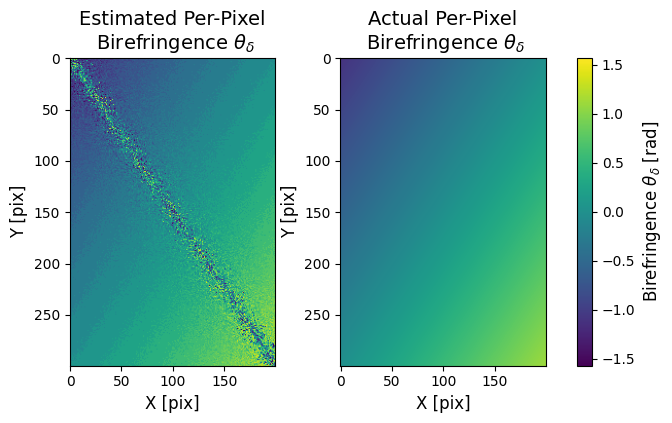

In [69]:
# Compare the per-pixel polarizance and estimated polarizance
plot_theta(p_est, phi)

Estimate both $\delta$ and $\theta_{\delta}$ using alternating iteration

In [66]:
d_est_b = zodipol.imager.get_birefringence_mat(np.pi/8, 'constant', flat=True)
p_est_b = zodipol.imager.get_birefringence_mat(np.pi/8, 'constant', flat=True)

In [68]:
real_mueller = zodipol.imager.get_birefringence_mueller_matrix(delta, phi)
est_mueller = zodipol.imager.get_birefringence_mueller_matrix(d_est_b, p_est_b)
mueller_err = ((real_mueller.reshape(est_mueller.shape) - est_mueller) ** 2).sum()
mueller_err_list = [mueller_err]
n_itr = 5
for ii in tqdm(range(n_itr)):
    d_est_b = estimate_delta(obs, biref_camera_intensity_stack, p_est_b.flatten(), n_d=10)
    p_est_b = estimate_theta(obs, biref_camera_intensity_stack, d_est_b.flatten(), n_d=10)
    est_mueller = zodipol.imager.get_birefringence_mueller_matrix(d_est_b, p_est_b)
    mueller_err = np.sqrt(((real_mueller.reshape(est_mueller.shape) - est_mueller) ** 2).sum())
    mueller_err_list.append(mueller_err)

100%|██████████| 5/5 [08:59<00:00, 107.93s/it]


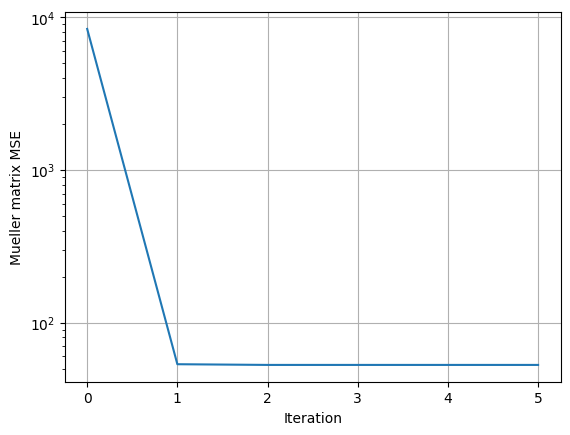

In [69]:
plt.figure()
plt.semilogy(mueller_err_list)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Mueller matrix MSE')
plt.savefig('outputs/biref_mueller_matrix_mse.pdf')
plt.show()

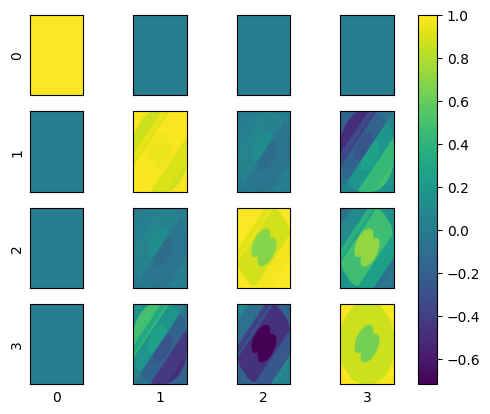

In [70]:
plot_mueller(est_mueller, cbar=True)

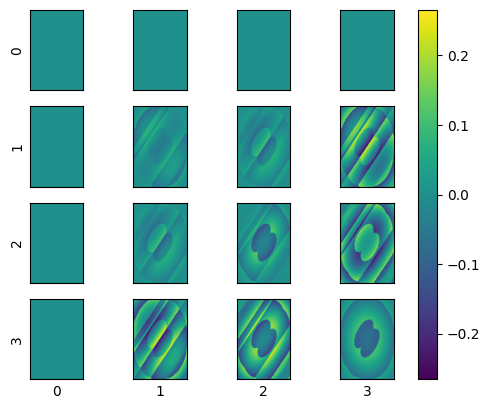

In [71]:
plot_mueller(est_mueller - real_mueller.reshape(est_mueller.shape), cbar=True)

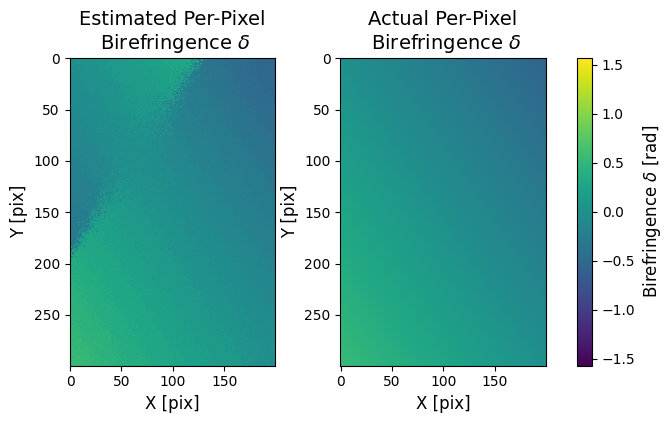

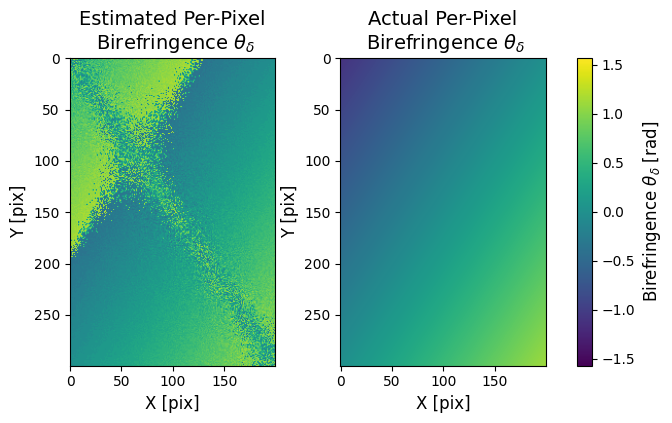

In [65]:
plot_delta(d_est_b, delta)
plot_theta(p_est_b, phi)